<div>
    <img src="./Pictures/elmer.jpeg" width="100"/>
<div>

# Template for Elmerfem notebook

This template allows running a Elmerfem case.sif file and handles the postprocessing. 
    
The steps are as follows:
1. Run the geometry and mesh builder, here [salome platform](https://www.salome-platform.org/)
2. Run `ElmerGrid` to convert the mesh format to a readible Elmer format
3. Run the case.sif file through the `ElmerSolver`
4. Run the postprocessing for 2D plots with pandas
5. Run the postprocessing via [paraview](https://www.paraview.org/) to handle fields


# Case study

The case study is a circular closed coil fed woith current coupling FEM and external circuit. The magnetic field, magnetic flux density and global variables (current, voltage) etc. are computed.

<table>
 <tr>
   <td><img src="./Pictures/coil.jpeg" width="300" /></td>
   <td><img src="./Pictures/circuit.jpeg" width="300" /></td>
 </tr>
 <tr>
   <td style="text-align:center">Coil geometry: FEM 1</td>
   <td style="text-align:center">Circuit</td>
 </tr>
</table>


# Create mesh and do the conversion

We use a bash file: `meshGeneration.sh`
```
#!/bin/bash

#Get salome. The user gives the absolute path to salome bin file
salome="/opt/SALOME-9.9.0-native-UB20.04-SRC/binsalome"
namef=$(find ./Salome -type f -name "main.py")
pathf=$(readlink -f $namef)

#Run salome to generate the *.unv file (mesh)
$salome -t $pathf

#Get the *.unv file and copy it in the local directory
name=$(find ./Salome -type f -name "assembly.unv")
cp -v $name .
#Get the geometric parameters to be used by Elmer solver
namedat=$(find ./Salome -type f -name "dataElmer.dat")
cp -v $namedat .

#remove the extension
filename=$(basename $name | cut -d. -f1)

#Clean the mesh folder and genrrate a new mesh for Elmer
rm -r ./MESH; ElmerGrid 8 2 $filename.unv -out MESH -autoclean -timer
#To visualize the mesh in gmsh format
ElmerGrid 2 4 MESH -out $filename.msh

```

In [8]:
import os
os.system('rm ./Log/mesh-*.log')
cmd_msh = 'bash meshGeneration.sh'
os.system(cmd_msh+' > ./Log/mesh-$(date +%s).log')

rm: cannot remove './Log/mesh-*.log': No such file or directory
Warning, no type found for resource "localhost", using default value "single_machine"
cp: './assembly.unv' and './assembly.unv' are the same file
cp: './dataElmer.dat' and './dataElmer.dat' are the same file


0

### Visualize the mesh

We use the gmsh formated mesh: `ElmerGrid 2 4 MESH -out $filename.msh`

In [9]:
import os
os.system('rm ./Log/gmsh-*.log')
cmd_gmsh = '/opt/onelab-Linux64/gmsh assembly.msh'
os.system(cmd_gmsh+' | tee -a ./Log/gmsh-$(date +%s).log')

rm: cannot remove './Log/gmsh-*.log': No such file or directory


0

# Run Elmer solver

Here we use directly `ElmerSolver`:
```
ElmerSolver case.sif > elmer-$(date +%s).log
```

In [10]:
import os
import time
tt = time.time()
ms = int(tt * 1000)
os.system('rm ./Log/elmer-*.log ./RESU/*')
cmd_elmer = 'ElmerSolver case.sif'
logfile='./Log/elmer-'+str(ms)+'.log'
os.system(cmd_elmer+' > '+logfile)
os.system('tail -n 5 '+logfile)

SaveScalars: Saving values to file: RESU/case.dat
ElmerSolver: *** Elmer Solver: ALL DONE ***
ElmerSolver: The end
SOLVER TOTAL TIME(CPU,REAL):        25.40       24.58
ELMER SOLVER FINISHED AT: 2022/08/09 09:27:10


0

# postprocessing on line

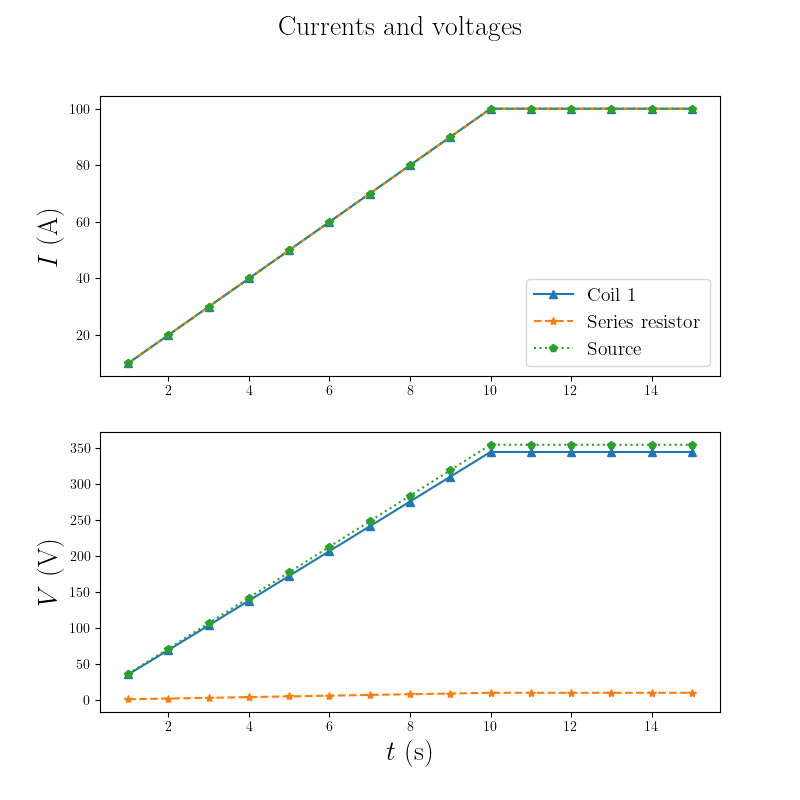

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

#Use interactive figure
%matplotlib widget

data = pd.read_csv('./RESU/case.dat', delim_whitespace=True, header=None)

names_file = open('./RESU/case.dat.names')
data.columns = [line.split('res: ')[1].replace('\n', '') for line in names_file.readlines() if 'res:' in line]

plt.rcParams.update({"text.usetex": True, "font.family": "DejaVu Sans", "font.sans-serif": ["Helvetica"]})
plt.rcParams['figure.figsize'] = [8, 8]
fig, (axs1, axs2) = plt.subplots(2, 1)
fig.suptitle('Currents and voltages', size=20)


axs1.plot(data['time'], data['i_component(1)'], marker="^", label='Coil 1')
axs1.plot(data['time'], data['i_rcl1'], linestyle='dashed', marker="*", label='Series resistor')
axs1.plot(data['time'], data['i_is1'], linestyle='dotted', marker="p", label='Source')
axs1.legend(fontsize=14, loc='lower right')
axs1.set_ylabel('$I$ (A)', fontsize = 20.0)

axs2.plot(data['time'], data['v_component(1)'], marker="^", label='Coil 1')
axs2.plot(data['time'], data['v_rcl1'], linestyle='dashed', marker="*", label='Series resistor')
axs2.plot(data['time'], data['v_is1'], linestyle='dotted', marker="p", label='Source')
axs2.set_ylabel('$V$ (V)', fontsize = 20.0)
axs2.set_xlabel(xlabel='$t$ (s)', fontsize = 20)


plt.savefig('./Python/currentVoltage.png')
plt.show()



# Vtu postprocessing

We use here paraview: `paraview --state=paraviewVisu.pvsm`
A pre-state was already written for a quick visualization

In [12]:
import os
#os.system('paraview --data=./RESU/case_t..vtu')
os.system('paraview --state=paraviewVisu.pvsm')

0